In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import GradientBoostingClassifier

import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Manage_data.db_manager import get_data

In [ ]:
df = get_data('META', granularity='daily')
df.drop(columns=['Title'], inplace=True)
df = df[df['Date'] >= df['Date'].max() - pd.DateOffset(months=36)]
df = df.sort_values(by="Date", ascending=True).reset_index(drop=True)
df = df[["Open"]].copy() 

In [ ]:
window_size = 30

for lag in range(1, window_size + 1):  
    df[f'lag_{lag}'] = df['Open'].shift(lag)

df.dropna(inplace=True)

Adding Symbol: META
entry already exists or no title
Erreur quadratique moyenne (MSE) : 11240.9579


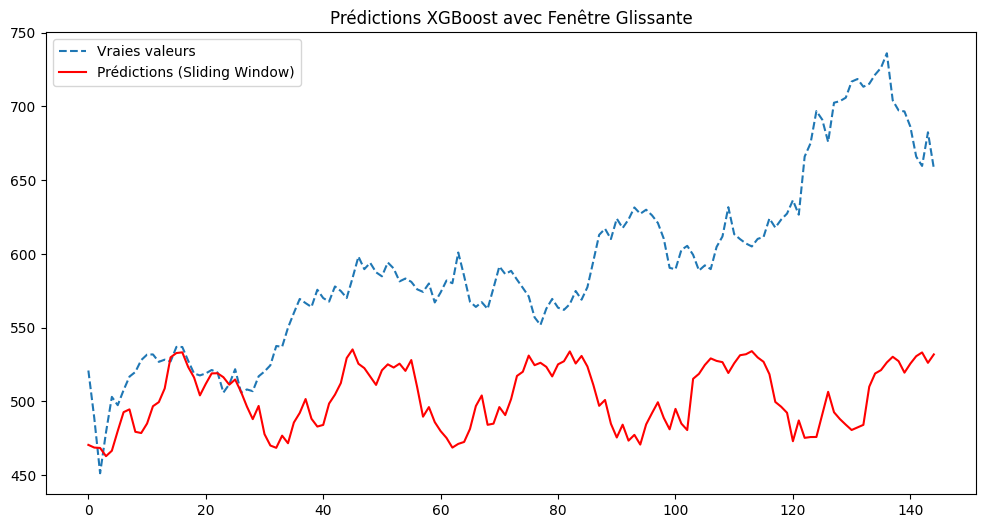

In [40]:
params = {
    "objective": "reg:squarederror",
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
}

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

predictions = []
real_values = df["Open"].iloc[train_size:].values

last_window = df.iloc[train_size - 1, 1:].values.reshape(1, -1)

for i in range(test_size):
    train_data = df.iloc[i : train_size + i]
    
    X_train = train_data.drop(columns=["Open"])
    y_train = train_data["Open"]
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(last_window)[0]
    predictions.append(y_pred)

    last_window = np.roll(last_window, -1)
    last_window[0, -1] = y_pred


Erreur quadratique moyenne (MSE) pour 20 jours : 736.5507


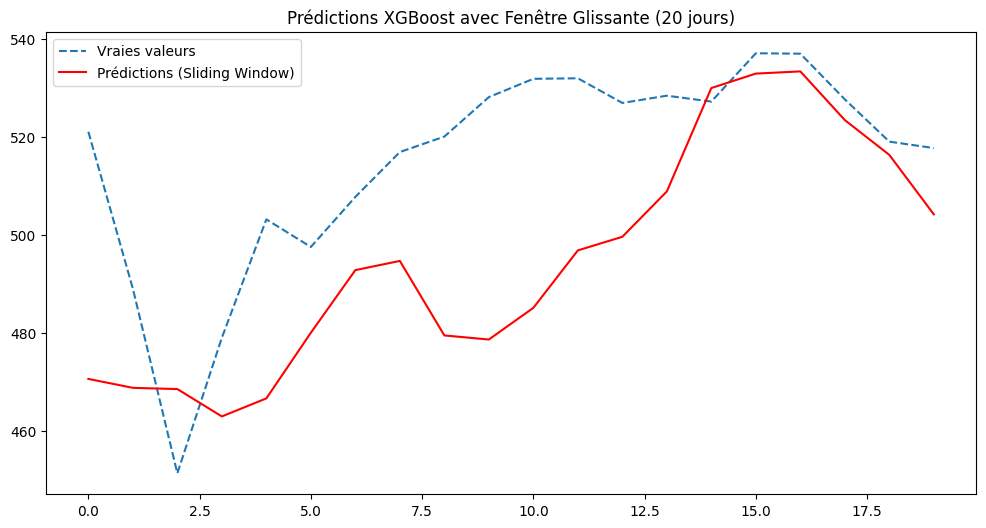

Erreur quadratique moyenne (MSE) pour 40 jours : 1629.0177


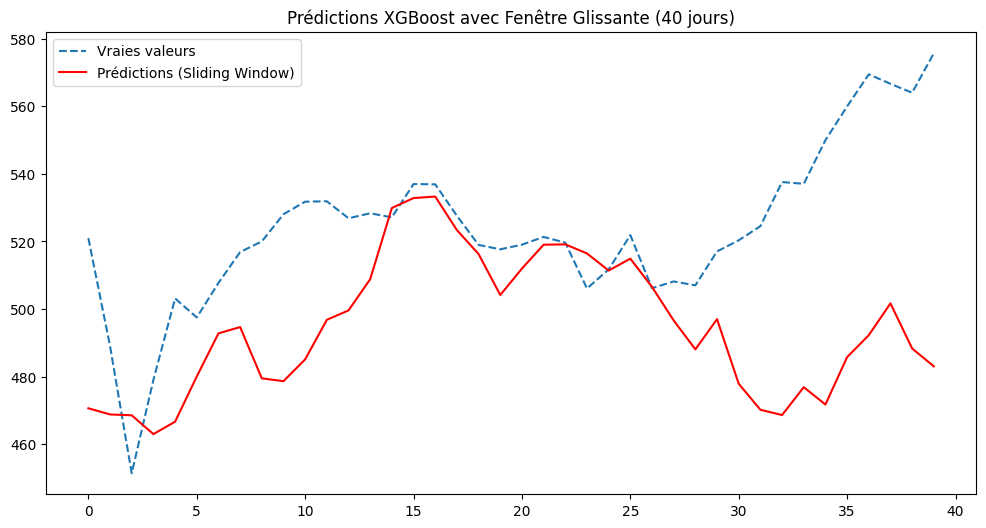

Erreur quadratique moyenne (MSE) pour 60 jours : 2674.0608


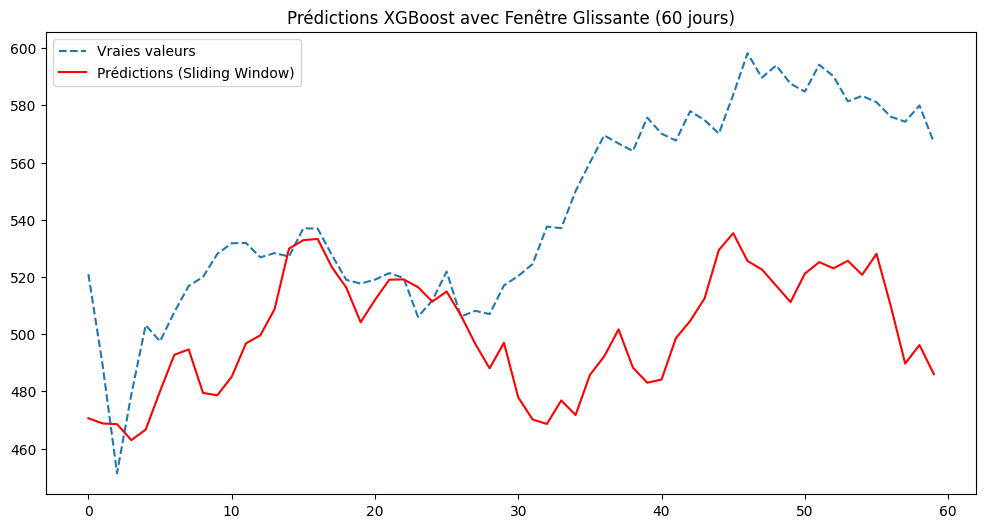

Erreur quadratique moyenne (MSE) pour 80 jours : 3674.8818


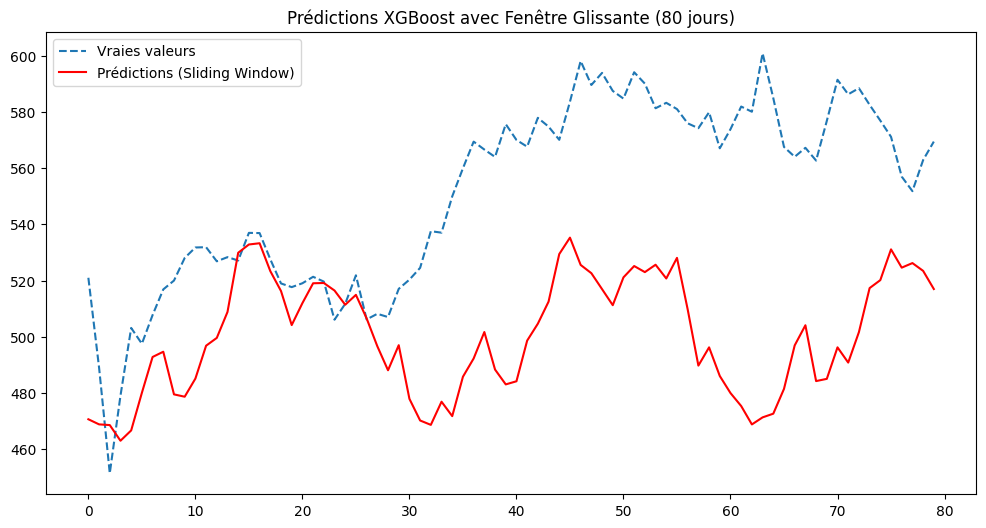

,XGBoost_20,XGBoost_40,XGBoost_60,XGBoost_80
mse,736.550696,1629.017726,2674.06082,3674.881764


In [50]:
results = {}

for predict_range in [20, 40, 60, 80]:
    mse = mean_squared_error(real_values[:predict_range], predictions[:predict_range])
    
    results[f"XGBoost_{predict_range}"] = {"mse ":mse}

    
    print(f"Erreur quadratique moyenne (MSE) pour {predict_range} jours : {mse:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(real_values[:predict_range], label="Vraies valeurs", linestyle='dashed')
    plt.plot(predictions[:predict_range], label="Prédictions (Sliding Window)", color='red')
    plt.legend()
    plt.title(f"Prédictions XGBoost avec Fenêtre Glissante ({predict_range} jours)")
    plt.savefig(f"figures/GB_{predict_range}.png", bbox_inches='tight')
    plt.show()

results = pd.DataFrame(results)
results
